#### Task : California Housing Price Prediction

Build a model that learn from California census data and predict housing prices in California. Dataset has features such as longitude, latitude, median income etc.

#### Supervised Regression Task



In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.preprocessing import Imputer,StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

#### Get Data

In [2]:
housing = pd.read_csv('housing.csv')    
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


#### Statistical Summary

In [4]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


#### Exploratory Data Analysis

<b> Ocean Proximity</b> is a categorical variable. Lets check what values it contain.

In [5]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

<b> ISLAND </b> has only 5 values. Its better to add these to other classes.

<Figure size 1440x1440 with 0 Axes>

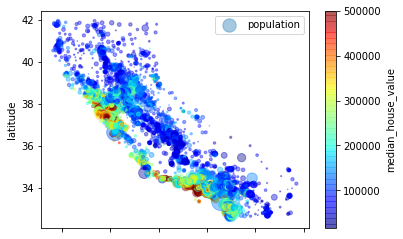

In [6]:
# visualizing geographical data
plt.figure(figsize=(20,20))

housing.plot(kind= ' scatter', x = 'longitude', y = 'latitude', alpha = 0.4,
             s = housing['population']/100, c ='median_house_value',label = 'population',
             cmap = plt.get_cmap('jet'), colorbar = True)
plt.legend()

Geographical graph shows some districts have high poplation as well as high median value. so, clearly location have some correlation with median house value.

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64


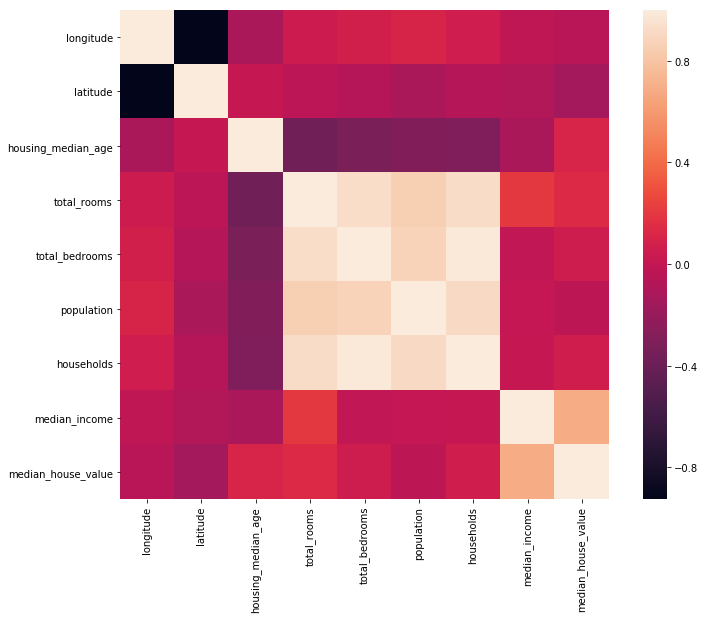

In [7]:
# correlation matrix
corr_matrix = housing.corr()
print(corr_matrix['median_house_value'].sort_values(ascending = False))

# generating a heat map
fig = plt.figure(figsize = (12,9))
sns.heatmap(corr_matrix, vmax = 1.0, square = True)
plt.show()

Correlation matrix approach is good for linear relationships but it can not identify correlation in non linear relationship. So, a better method is to plot scatter matrix of every numerical attribute against every other numerical attribute.

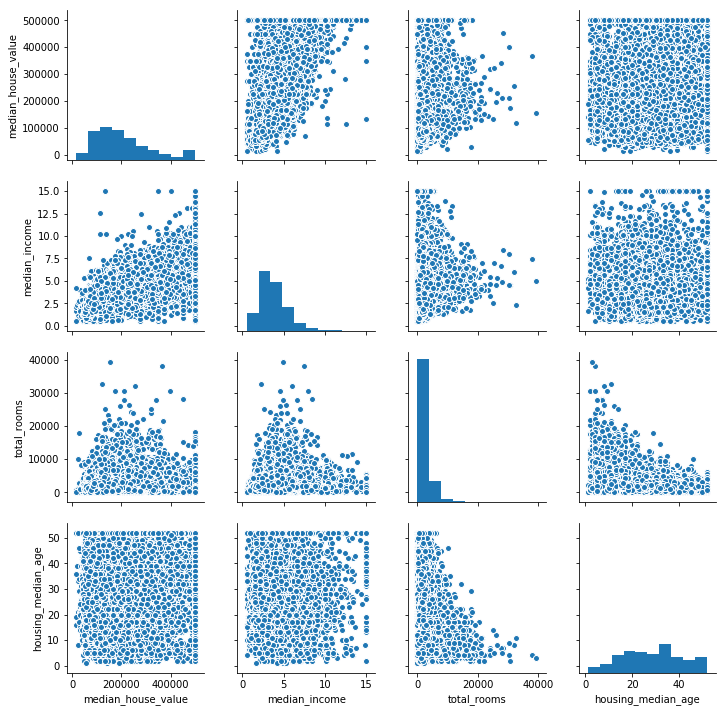

In [8]:
# attributes = ['median_house_value',"median_income", "total_rooms","housing_median_age"]
# pd.plotting.scatter_matrix(housing[attributes], figsize=(12, 9))
# plt.show()

sns.pairplot(housing[['median_house_value','median_income','total_rooms','housing_median_age']])

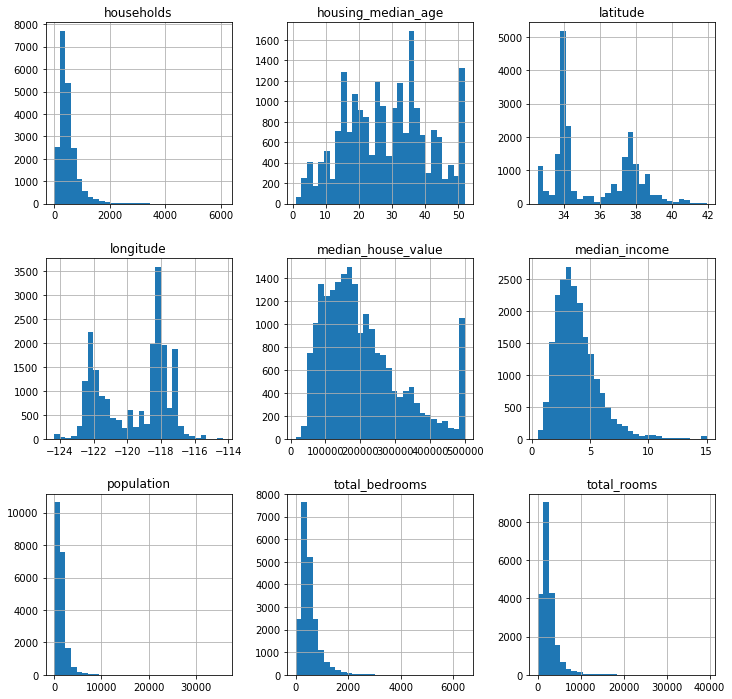

In [9]:
housing.hist(bins = 30, figsize = (12, 12))
plt.show()

Text(0.5,1,'Frequency distribution of median_house_value')

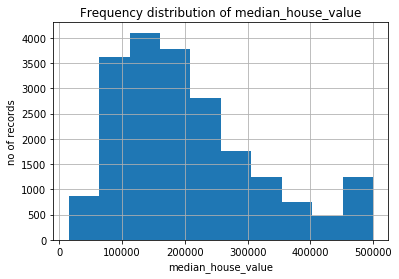

In [10]:
# check target distribution
housing['median_house_value'].hist()
plt.xlabel('median_house_value')
plt.ylabel('no of records')
plt.title('Frequency distribution of median_house_value')

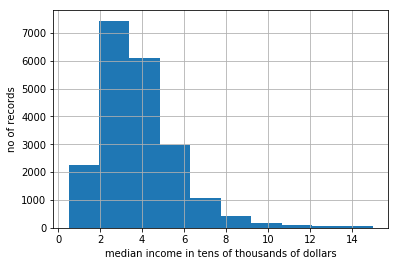

In [11]:
#### median income is an important attribute so check distribution 
housing['median_income'].hist()
plt.xlabel('median income in tens of thousands of dollars')
plt.ylabel('no of records')
plt.show()

#### Insights From EDA
* scaling
* ocean_proximaty categorical 5  
* missing value in total_bedrooms 207
* median income capped at 15000 and 0.5K in usd
* house median age and house median value also capped
* many attributes are tail heavy...transformation
* need to convert median income in bell shape
* quirks in scatter matrix specially in median income around 4.50k, 3.50k

#### Feature Engineering

In [12]:
# housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
# housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
# housing["population_per_household"]=housing["population"]/housing["households"]

class FeaturesAdder(BaseEstimator,TransformerMixin):
    """This class adds new features in the dataset.
        Features added are : rooms_per_household, bedrooms_per_room, and population_per_household.
    """
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        X['rooms_per_household']=X['total_rooms']/X['households']
        X['bedrooms_per_room']=X['total_bedrooms']/X['total_rooms']
        X['population_per_household']=X['population']/X['households']
        return X
housing = FeaturesAdder().fit_transform(housing)

In [13]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

So, correlation of new features is better with target variable. Later I will code feature extraction in a class to use in Pipeline.

#### Removing outliers

In [14]:
num_features=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'rooms_per_household',
       'bedrooms_per_room', 'population_per_household']

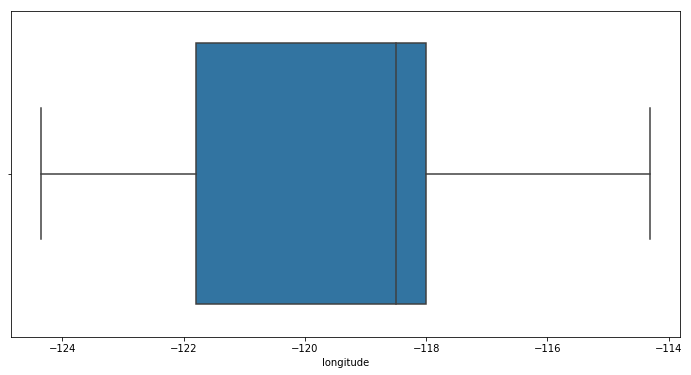

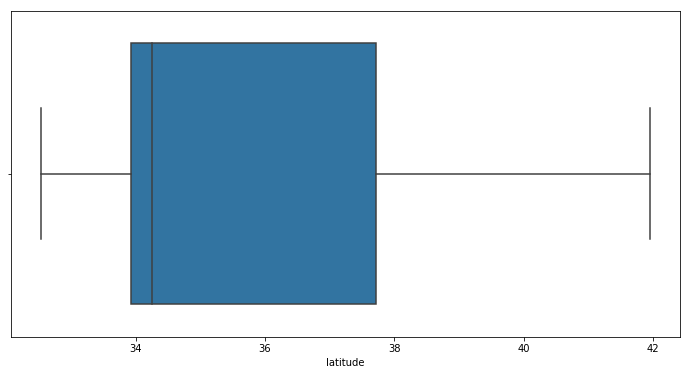

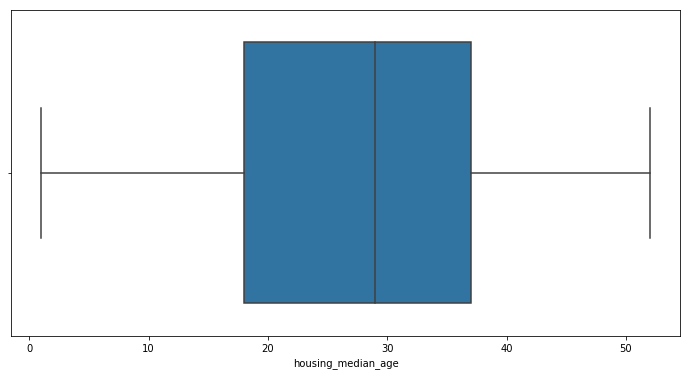

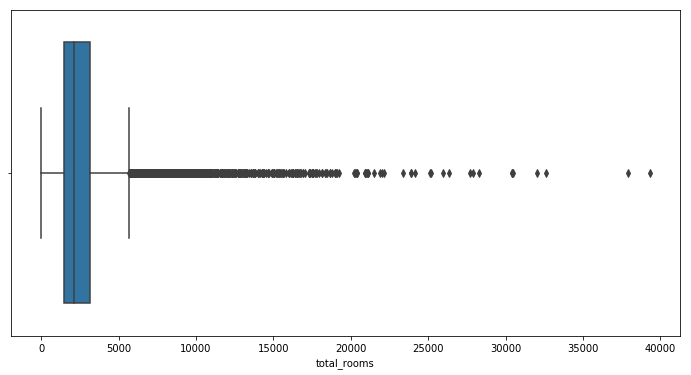

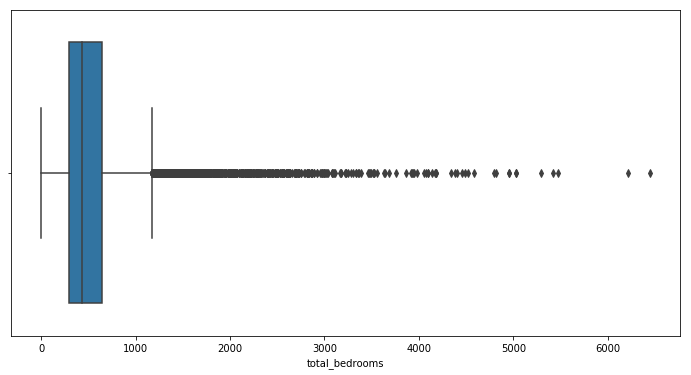

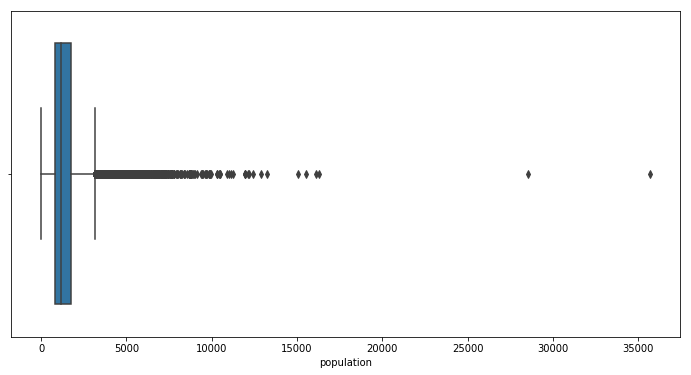

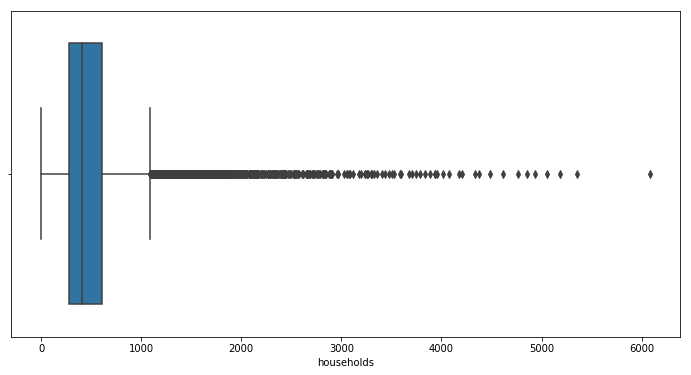

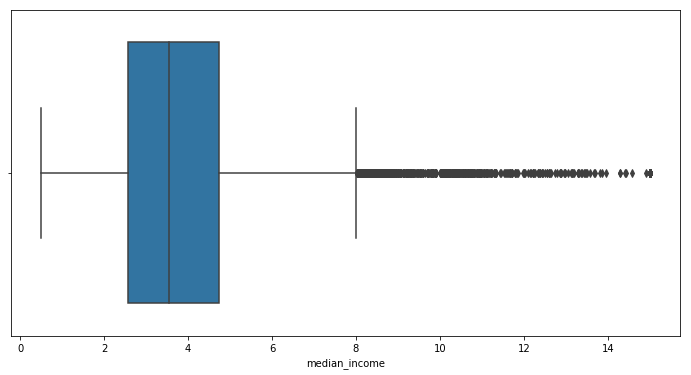

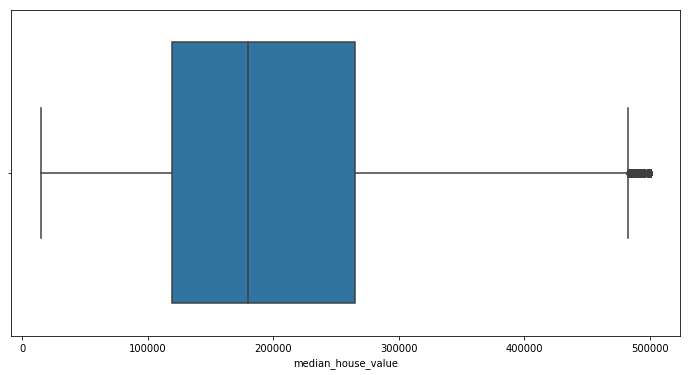

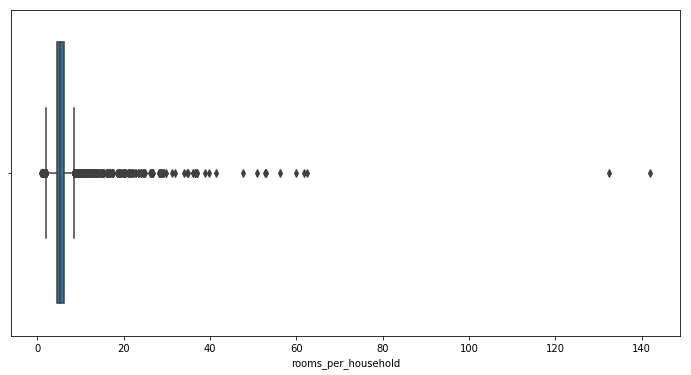

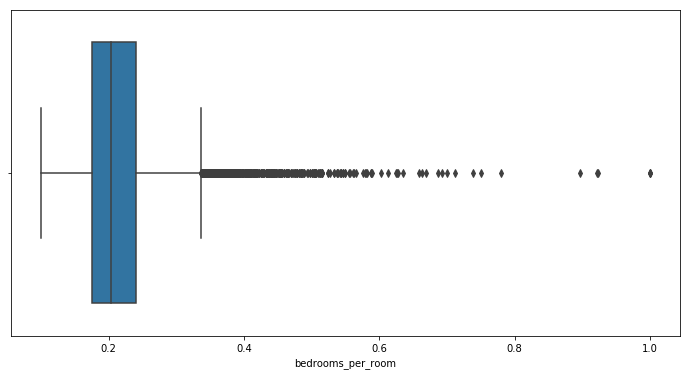

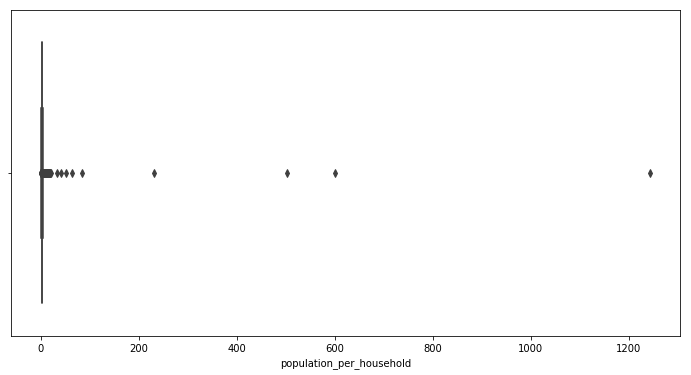

In [15]:
for i in num_features:
    fig, ax = plt.subplots()
    fig.set_size_inches(12,6)
    #plt.xlim(-10,10)
    sns.boxplot(x=i,data=housing,ax=ax)

In [16]:
class RemoveOutliers(BaseEstimator,TransformerMixin):
    """This class removes outliers from data.
    Note: Outlier values are hard coded
    """
    def fit (self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        X=X[(X['median_house_value']!=500001) | (X['median_income']>=2)].reset_index(drop=True)
        X=X[X['median_income']<=11].reset_index(drop=True)
        X=X[(X['median_house_value']!=350000) | (X['median_income']>=1.5)].reset_index(drop=True)
        X=X[(X['median_house_value']!=450000) | (X['median_income']>=2)].reset_index(drop=True)
        X=X[(X['median_house_value']>=350000) | (X['median_income']<=9.5)].reset_index(drop=True)
        X=X[X['population']<=9000]
        X=X[(X['population_per_household']>=1.15) & (X['population_per_household']<=6.5)]
        X=X[X['rooms_per_household']<20]
        X=X[X['bedrooms_per_room']<0.5].reset_index(drop=True)
        return X

In [17]:
housing = RemoveOutliers().fit_transform(housing)

As I have added new features and removed outliers from the dataset, Now its time to separate features and label.

In [18]:
housing_label = housing['median_house_value']
housing_feature = housing.drop('median_house_value', axis =1)

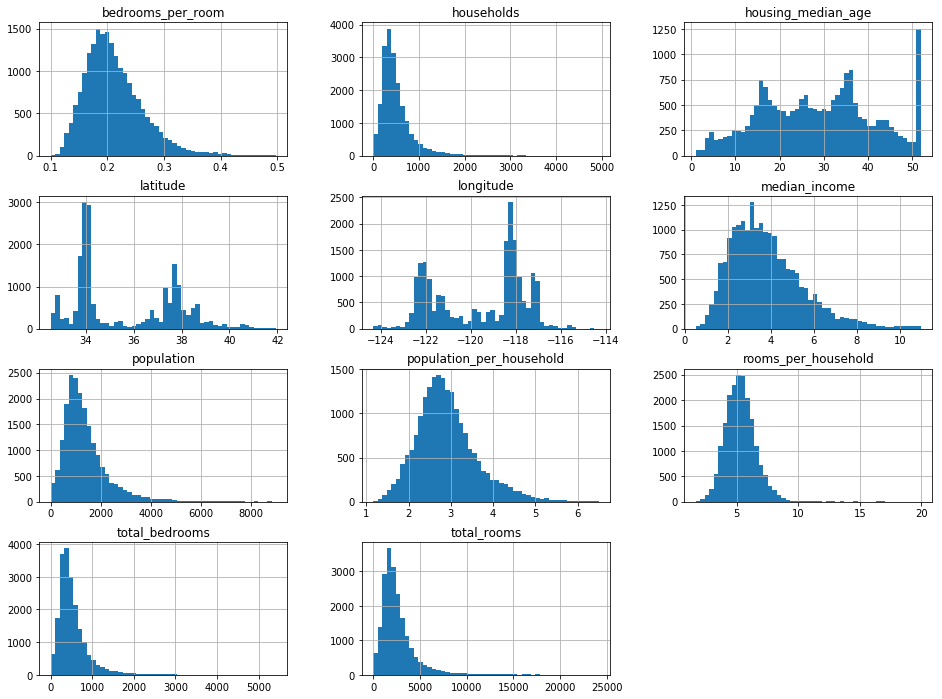

In [19]:
housing_feature.hist(bins=50,figsize=(16,12))
plt.show()

#### Transforming skewed features

In [20]:
# redefine numerical features dropping labe;
num_features=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_household',
       'bedrooms_per_room', 'population_per_household']

Get **skewness** of features

In [21]:
skewness=[]
for i in num_features:
    skewness.append(housing_feature[i].skew())
pd.DataFrame(data=skewness,index=num_features,columns=['skewness']).sort_values(by='skewness',ascending=False)

,skewness
total_rooms,3.001332
total_bedrooms,2.758726
households,2.646305
population,2.446828
rooms_per_household,2.108417
bedrooms_per_room,1.169679
median_income,1.043503
population_per_household,0.901090
latitude,0.464141
housing_median_age,0.060741


I transformed features using **log1p** and **boxcox1p** functions.

boxcox1p is used for highly skewed features

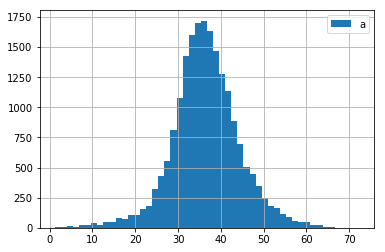

In [22]:
housing_feature['households'].apply(lambda x: np.log1p(x)**2).hist(bins=50,label='a')
plt.legend()

In [23]:
class FeaturesTransformer(BaseEstimator,TransformerMixin):
    """This class trnsforms numberical featuress in the dataset.
    Note: Transformations are hard coded.
    """
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        from scipy.special import boxcox1p        
        X['total_rooms']=X['total_rooms'].apply(lambda x: boxcox1p(x,0.25))
        X['total_bedrooms']=X['total_bedrooms'].apply(lambda x: boxcox1p(x,0.25))
        X['households']=X['households'].apply(lambda x: boxcox1p(x,0.2))
        X['population']=X['population'].apply(lambda x: boxcox1p(x,0.3))
        X['rooms_per_household']=X['rooms_per_household'].apply(lambda x: np.log1p(x)**0.5)
        X['bedrooms_per_room']=X['bedrooms_per_room'].apply(lambda x: np.log1p(x)**0.25)
        X['median_income']=X['median_income'].apply(lambda x: np.log1p(x)**1.25)
        X['population_per_household']=X['population_per_household'].apply(lambda x: np.log1p(x)**1)
        return X
housing_feature = FeaturesTransformer().fit_transform(housing_feature)

** Transformed features **

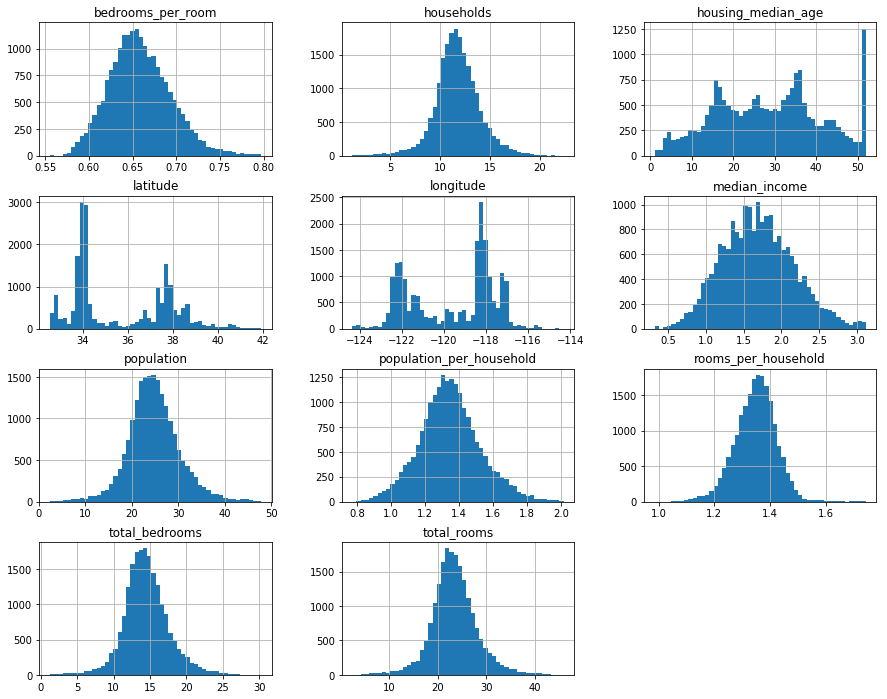

In [24]:
housing_feature.hist(bins=50,figsize=(15,12))
plt.show()

** Data Preprocessing and Pipeline **

In [25]:
class DataFrameSelector(BaseEstimator,TransformerMixin):
    """This class is a dataframe selector.
        Data members:
            features: A list of column_names you want in output dataframe
    """
    def __init__(self,features):
        self.features=features
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return X[self.features]
# TransformerMixin: no need to write fit_transform if we use TransformerMixin
# No need to use *args and **kwarrgs if we use BaseEstimator

LabelBinarizer is not supposed to be used with X (Features), but is intended for labels only. Hence the fit and fit_transform methods are changed to include only single object y. But the Pipeline (which works on features) will try sending both X and y to it. Hence the error. so, using MyLabelBinarizer.

<a href> 'https://stackoverflow.com/questions/46162855/fit-transform-takes-2-positional-arguments-but-3-were-given-with-labelbinarize'</a>

In [26]:
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        #change ISLAND to NEAR BAY...as count of ISLAND is very low
        x[x=='ISLAND']='NEAR BAY'
        return self.encoder.transform(x)

In [27]:
num_features=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_household','bedrooms_per_room', 'population_per_household']
cat_features=['ocean_proximity']

In [28]:
num_pipeline = Pipeline([
                        ('selector', DataFrameSelector(num_features)),
                        ('imputer', Imputer(strategy= 'median')),
                        ('scaling', StandardScaler()),
                  ])

cat_pipeline = Pipeline([
                        ('selector', DataFrameSelector(cat_features)),
                        ('labelBinarizer', MyLabelBinarizer()),
                ])

p1 = FeatureUnion(transformer_list=[
                                   ("num_pipeline", num_pipeline),
                                    ("cat_pipeline", cat_pipeline),
                                  ])

This is all the data manupulation I have done.
Following is the summarization:
1. Adding new featues
2. Removing outliers
3. Transforming skewed features
4. Null value imputation
5. categorical variable for ocean_proximity
6. Standard scaling
